Notebook 5: In which we use fully-connected neural networks to identify fish, do a lousy job and ask you to improve upon it by using convolutional neural networks (CNN)
------------------------------------------------------------------------------------------
We will use miniCARP, a restricted version of a library of fish images prepared by the lab as part of __[idtracker.ai](http://idtracker.ai)__ paper  

In [1]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import keras.backend as K
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
CARP_PATH = './miniCARP/' # miniCARP should be already in this folder. Please let us know otherwise
def load_carp(fraction=1.0):
    folder = os.path.expanduser(CARP_PATH)
    images = np.load(os.path.join(folder,'miniCARP_images.npy'))
    labels = np.load(os.path.join(folder,'miniCARP_labels.npy'))
    num_images = int(np.floor(images.shape[0]*fraction))
    return images[:num_images], labels[:num_images]
images_uint8, all_labels = load_carp(fraction=0.1)

In [3]:
print(images_uint8.shape, all_labels.shape)
print(images_uint8.dtype, all_labels.dtype)
print(images_uint8.min(), images_uint8.max())
print(all_labels, all_labels.min(), all_labels.max())
NUM_LABELS = all_labels.max()+1


(7500, 52, 52) (7500,)
uint8 uint8
0 234
[10  3 10 ...  2  0 13] 0 14


As usual, we transform images to a 0 to 1 range and then remove the mean pixel intensity

In [4]:
all_images = images_uint8 / images_uint8.max()
all_images = all_images - all_images.mean()
print("New range: {} to {}".format(all_images.min(), all_images.max()))

New range: -0.10848107162123419 to 0.8915189283787658


Here, we print some examples, together with the labels. Feel free to change the range of images and labels to be shown

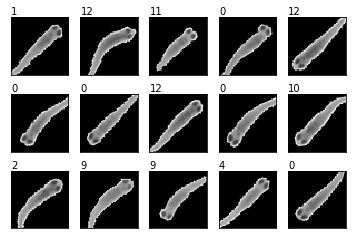

In [5]:
def show_images(images, labels=None):
    fig, axes_rows = plt.subplots(3, len(images)//3)
    axes = [ax for rows in axes_rows for ax in rows]
    for image, ax in zip(images, axes):
        ax.imshow(image,cmap=plt.cm.binary_r)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    if labels is not None:
        for label, ax in zip(labels, axes):
            ax.text(0, -3, label)
    plt.show()
show_images(all_images[200:215], labels=all_labels[200:215]) # Change range here to print other images

We divide the dataset into disjoint train/validation/test datasets

In [6]:
VALIDATION_FRAMES = 1000
TEST_FRAMES = 1000
def partition_data(data, validation=VALIDATION_FRAMES, test=TEST_FRAMES):
    assert validation + test < data.shape[0]
    return {"train": data[validation:-test],
            "validation": data[:validation],
            "test": data[-test:]}

labels = partition_data(to_categorical(all_labels))
images = partition_data(all_images)

print("Validation and test are fractions {:.2g} and {:.2g}".format(images['validation'].shape[0]/all_images.shape[0],
                                                                   images['test'].shape[0]/all_images.shape[0]))


Validation and test are fractions 0.13 and 0.13


In [7]:
images_flat = {key: images[key].reshape((-1, 52*52)) for key in ['train', 'validation', 'test']}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 5500 samples, validate on 1000 samples
Epoch 1/50
5500/5500 [==============================] - 1s 185us/step - loss: 2.3441 - acc: 0.2135 - val_loss: 2.0165 - val_acc: 0.2810
Epoch 2/50
5500/5500 [==============================] - 0s 42us/step - loss: 1.7243 - acc: 0.4191 - val_loss: 1.6742 - val_acc: 0.4550
Epoch 3/50
5500/5500 [==============================] - 0s 47us/step - loss: 1.3693 - acc: 0.5385 - val_loss: 1.4995 - val_acc: 0.4960
Epoch 4/50
5500/5500 [==============================] - 0s 47us/step - loss: 1.1015 - acc: 0.6345 - val_loss: 1.2145 - val_acc: 0.6030
Epoch 5/50
5500/5500 [==============================] - 0s 46us/step - loss: 0.8904 - acc: 0.6945 - val_loss: 1.1767 - val_acc: 0.6080
Epoch 6/50
5500/5500 [==============================] - 0s 42us/step - loss: 0.8049 - acc: 0.7229 - val_loss: 1.0871 - val_acc: 0.6550
Epoch 7/50
5500/5500 

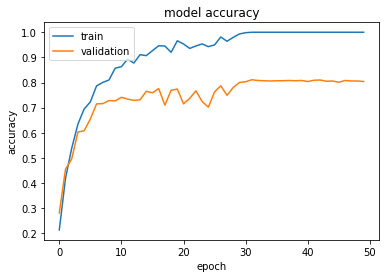

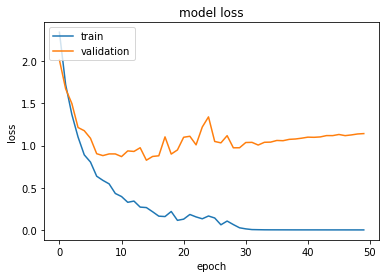

test_acc: 0.823


In [8]:
network_fc = models.Sequential()
network_fc.add(layers.Dense(1024, activation='relu', input_shape=(52 * 52,)))
network_fc.add(layers.Dense(512, activation='relu'))
network_fc.add(layers.Dense(512, activation='relu'))
network_fc.add(layers.Dense(NUM_LABELS, activation='softmax'))
network_fc.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = network_fc.fit(images_flat['train'], labels['train'],
               validation_data=(images_flat['validation'], labels['validation']), 
               epochs=50, batch_size=128)
test_loss, test_acc = network_fc.evaluate(images_flat['test'], labels['test'])

def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(history)
print('test_acc:', test_acc)

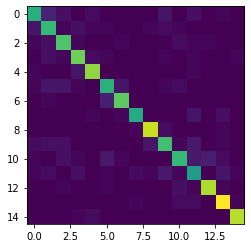

In [9]:
from sklearn.metrics import confusion_matrix
labels_predict=network_fc.predict(images_flat['test'])
labels_predict=np.argmax(labels_predict, axis=1)
confusion_test=confusion_matrix(np.argmax(labels['test'], axis=1), labels_predict)
plt.imshow(confusion_test, interpolation='none')
plt.show()

It does not seem too effective... Let us try a convolutional neural network (CNN)!

We will explain what a convolutional neural network is using the whiteboard. Then, we expect you to implement it in Keras (that will be **Ex 1** of this notebook). You can look at Keras documentation and this relevant example: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

The first step to use a CNN would to reshape the images as (num images,width, height, color channels):

In [10]:
images_cnn = {key: images[key].reshape((-1, 52, 52, 1)) for key in ['train', 'validation', 'test']}


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 5500 samples, validate on 1000 samples
Epoch 1/50
5500/5500 [==============================] - 1s 254us/step - loss: 2.5796 - acc: 0.1365 - val_loss: 2.2129 - val_acc: 0.3070
Epoch 2/50
5500/5500 [==============================] - 1s 118us/step - loss: 1.9199 - acc: 0.3795 - val_loss: 1.5238 - val_acc: 0.5400
Epoch 3/50
5500/5500 [==============================] - 1s 127us/step - loss: 1.3833 - acc: 0.5431 - val_loss: 1.1450 - val_acc: 0.6540
Epoch 4/50
5500/5500 [==============================] - 1s 105us/step - loss: 1.0522 - acc: 0.6555 - val_loss: 0.8846 - val_acc: 0.7320
Epoch 5/50
5500/5500 [==============================] - 1s 108us/step - loss: 0.8479 - acc: 0.7218 - val_loss: 0.7330 - val_acc: 0.7860
Epoch 6/50
5500/5500 [==============================] - 1s 106us/step - loss: 0.7411 - acc: 0.7575 - val_loss: 0.6596 - val_acc: 0.8120
Epoch 7/50
5500/5500 

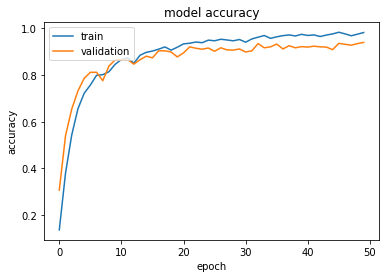

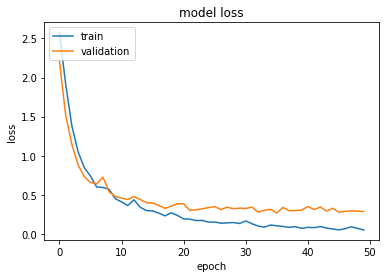

test_acc: 0.932


In [11]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(16, (7, 7), padding='same', input_shape=(52, 52, 1), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(layers.Conv2D(32, (7, 7), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(512, activation='relu'))
cnn.add(layers.Dense(NUM_LABELS, activation='softmax'))
cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history=cnn.fit(images_cnn['train'], labels['train'],
               validation_data=(images_cnn['validation'], labels['validation']), 
               epochs=50, batch_size=128)
test_loss, test_acc = cnn.evaluate(images_cnn['test'], labels['test'])


plot_history(history)

print('test_acc:', test_acc)

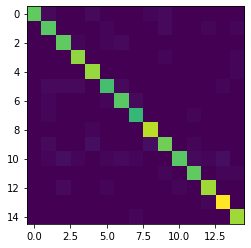

In [14]:
from sklearn.metrics import confusion_matrix
labels_predict=cnn.predict(images_cnn['test'])
labels_predict=np.argmax(labels_predict, axis=1)
confusion_test=confusion_matrix(np.argmax(labels['test'], axis=1), labels_predict)
plt.imshow(confusion_test, interpolation='none')
plt.show()

In [15]:
del(network_fc)
del(cnn)
K.clear_session()
gc.collect()

5222